## Iteration 1

In [7]:
import sys
import os
sys.path.append(os.path.abspath("../.."))

train_dir = "../../Data Set Ordered/training data/"
val_dir = "../../Data Set Ordered/validation data/"
test_dir = "../../Data Set Ordered/test data/"

In [8]:
from keras.applications import MobileNetV3Small
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.optimizers import SGD
from keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
)


# Train generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
    val_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
)

# Validation generator
test_generator = train_datagen.flow_from_directory(
    test_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
)

base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
      layer.trainable = False

  # Add custom layers for classification
x = base_model.output
x = Flatten()(x)
preds = Dense(7,activation='softmax')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=preds)

sgd = SGD()

# Compile model - make it trainable
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])



Found 10015 images belonging to 7 classes.
Found 193 images belonging to 7 classes.
Found 1512 images belonging to 7 classes.


In [9]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='models/best_model_iteration_1.h5',
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',  
    patience=15,          
    min_delta=0.001      
)

# Train the model with the callback
history2 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    verbose=1,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 7.9159 - accuracy: 0.6743
Epoch 1: val_loss improved from inf to 4.99858, saving model to models/best_model_iteration_1.h5
313/313 [==============================] - 31s 96ms/step - loss: 7.9159 - accuracy: 0.6743 - val_loss: 4.9986 - val_accuracy: 0.6736
Epoch 2/50


/Users/sebastiangodske/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - ETA: 0s - loss: 4.3544 - accuracy: 0.7628
Epoch 2: val_loss improved from 4.99858 to 3.49319, saving model to models/best_model_iteration_1.h5
313/313 [==============================] - 31s 99ms/step - loss: 4.3544 - accuracy: 0.7628 - val_loss: 3.4932 - val_accuracy: 0.7876
Epoch 3/50
313/313 [==============================] - ETA: 0s - loss: 3.0364 - accuracy: 0.8182
Epoch 3: val_loss improved from 3.49319 to 2.59536, saving model to models/best_model_iteration_1.h5
313/313 [==============================] - 32s 101ms/step - loss: 3.0364 - accuracy: 0.8182 - val_loss: 2.5954 - val_accuracy: 0.7824
Epoch 4/50
313/313 [==============================] - ETA: 0s - loss: 2.0969 - accuracy: 0.8480
Epoch 4: val_loss did not improve from 2.59536
313/313 [==============================] - 31s 99ms/step - loss: 2.0969 - accuracy: 0.8480 - val_loss: 2.9105 - val_accuracy: 0.7668
Epoch 5/50
313/313 [==============================] - ETA: 0s - loss: 1.69

['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6']
Balanced Accuracy: 0.48421284675060117
Accuracy on test set: 0.7195767164230347
F1 Score: 0.7098214070719328


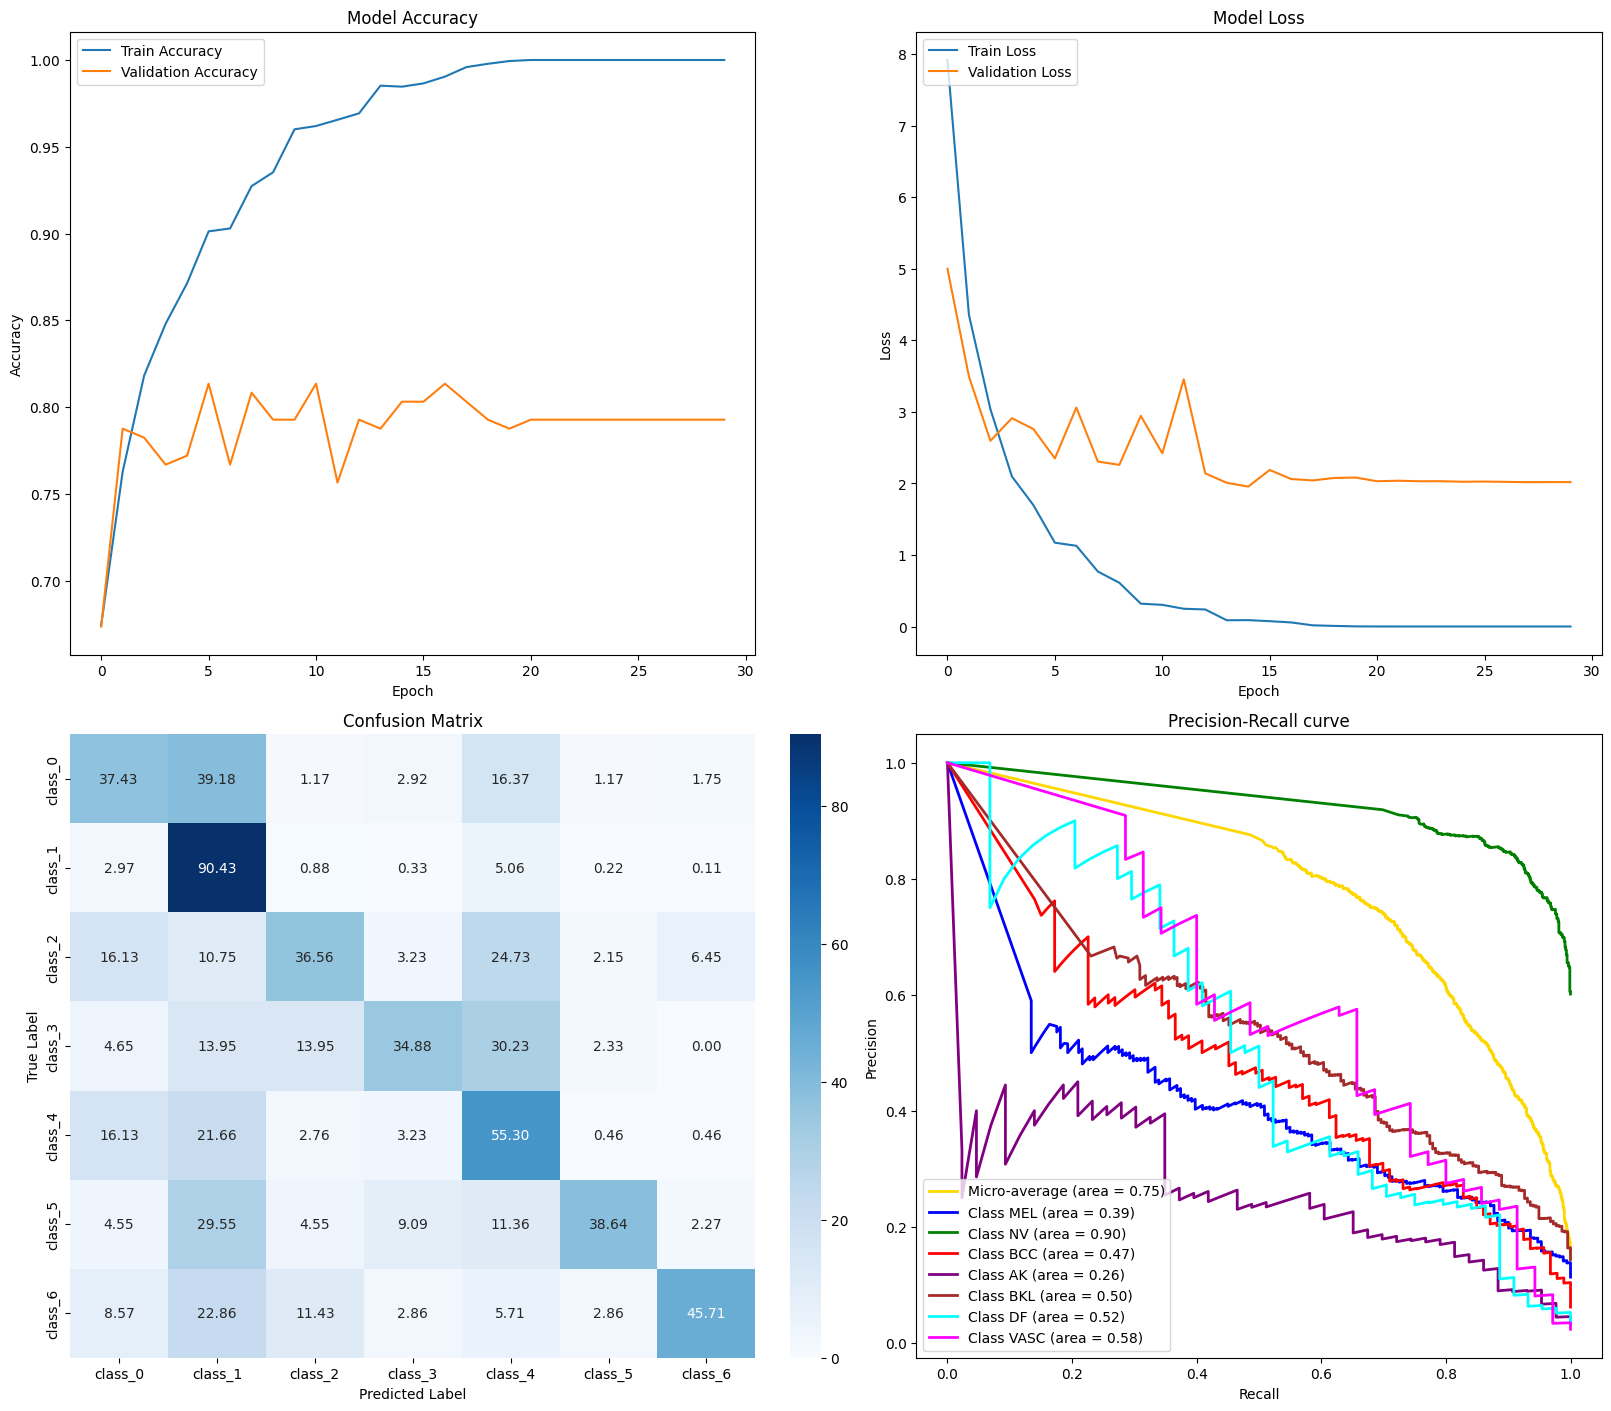

In [19]:
from tensorflow.keras.models import load_model


model = load_model('models/best_model_iteration_1.h5')

show_all_plots(history2, model, test_generator)

### What did we learn????

- Overfitting:
    - yes, we think
- Efficiency:
    - Super fint - den er hurtig (30 sec per epoch - 100=51 min)
- Performance:
    - Accuracy -> train=100, val=77.72, test: 70.42
    - loss -> train=fuckinglav, val=1.84854, test=4.7873

Takaways:
- We do not overfit, so we can try with a more complex model?
- We did not expect it to learn to differentiate between the 7 classes as they are very unbalanced.
- We did not expect it to learn this much
- It doesnt learn that well for val/test and there is a large gap between train and the others

What to do next time?
- Experiment with Learning Rate
    - we can observe that model has "plateaued", meaning that the validation loss neither goes up or down, 
    with the use of a Learning Rate Scheduler we could force the model out of the plateau and maybe achieve a lower loss (maybe?).
    - week 6 slide11
- Experiment with Regularization 
    - we can observe that there is a significant difference between the loss in train and val. This can be tackle by implementing regularization techniques.
        - Data augmentation
        - Early Stopping! (always do this)
        - Dropout
        - Add Noise when training

# PLot

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, precision_recall_curve, average_precision_score, f1_score
from sklearn.preprocessing import label_binarize

class CombinedHistory:
    def __init__(self, combined_history_dict):
        self.history = combined_history_dict

def combine_histories(histories):
    combined_history = {}
    for key in histories[0].history.keys():
        combined_history[key] = []
        for history in histories:
            combined_history[key].extend(history.history[key])
    return CombinedHistory(combined_history)

# Define the function to plot all metrics including balanced accuracy
def show_all_plots(histories, model, validation_generator):


    if isinstance(histories, list):  # Check if it's a list of histories
        history = combine_histories(histories)
    else:  # If single history is passed, use it directly
        history = histories
    


    # Assuming `validation_generator` has class indices mapped to class names
    class_names = list(validation_generator.class_indices.keys())
    print(class_names)

    # Calculate balanced accuracy for each epoch

    # Get true labels and predictions for the entire validation set
    y_true = []
    y_pred = []

    for i in range(len(validation_generator)):
        X_val_batch, y_val_batch = validation_generator[i]
        y_pred_batch = model.predict(X_val_batch, verbose=0)
        y_pred.extend(y_pred_batch)  # Keep the raw probabilities for precision-recall
        y_true.extend(y_val_batch)   # Keep the one-hot encoded true labels

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate balanced accuracy, confusion matrix, and F1 score
    y_true_labels = np.argmax(y_true, axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)
    balanced_acc = balanced_accuracy_score(y_true_labels, y_pred_labels)
    conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
    conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1, keepdims=True) * 100


    # Print metrics
    print(f"Balanced Accuracy: {balanced_acc}")
    print(f"Accuracy on test set: {model.evaluate(validation_generator, verbose=0)[1]}")
    print(f"F1 Score: {f1_score(y_true_labels, y_pred_labels, average='weighted')}")

    # Set up a 2x2 grid for the plots
    plt.figure(figsize=(16,14), constrained_layout=True)
    
    # 1. Accuracy plot
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # 2. Loss plot
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # 3. Confusion matrix plot
    plt.subplot(2, 2, 3)
    sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # 4. Precision-Recall Curve plot
    plt.subplot(2, 2, 4)
    show_precision_recall(y_true, y_pred)

    # Show all the plots
    plt.show()

def show_precision_recall(y_test, predictions):
    class_names = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC']
    
    # Binarize the output for multiclass
    y_test = label_binarize(y_test, classes=range(len(class_names)))
    predictions = np.array(predictions)

    precision = dict()
    recall = dict()
    average_precision = dict()
    
    # Compute Precision-Recall and average precision for each class
    for i in range(len(class_names)):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], predictions[:, i])
        average_precision[i] = average_precision_score(y_test[:, i], predictions[:, i])

    # Compute micro-average Precision-Recall curve and area
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(), predictions.ravel())
    average_precision["micro"] = average_precision_score(y_test, predictions, average="micro")
    
    # Plot Precision-Recall curve
    plt.plot(recall["micro"], precision["micro"], color='gold', lw=2, label=f'Micro-average (area = {average_precision["micro"]:0.2f})')
    for i, color in enumerate(['blue', 'green', 'red', 'purple', 'brown', 'cyan', 'magenta']):
        plt.plot(recall[i], precision[i], color=color, lw=2, label=f'Class {class_names[i]} (area = {average_precision[i]:0.2f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend(loc='best')
